In [1]:
import os
from matplotlib import pyplot as plt

os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [3]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

nepochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loader = DataLoader(mnist_data, batch_size=64, sampler=RandomSampler(mnist_data))
loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
running_loss = 0
for epoch in range(nepochs):
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch:{epoch+1}/{nepochs}"):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")

Epoch:1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:1/10: 100%|██████████| 938/938 [00:15<00:00, 60.52it/s]


running_loss=0.341


Epoch:2/10: 100%|██████████| 938/938 [00:15<00:00, 60.27it/s]


running_loss=0.660


Epoch:3/10: 100%|██████████| 938/938 [00:15<00:00, 61.16it/s]


running_loss=0.083


Epoch:4/10: 100%|██████████| 938/938 [00:15<00:00, 61.07it/s]


running_loss=0.057


Epoch:5/10: 100%|██████████| 938/938 [00:15<00:00, 60.16it/s]


running_loss=0.127


Epoch:6/10: 100%|██████████| 938/938 [00:16<00:00, 56.47it/s]


running_loss=0.034


Epoch:7/10: 100%|██████████| 938/938 [00:15<00:00, 59.38it/s]


running_loss=0.035


Epoch:8/10: 100%|██████████| 938/938 [00:16<00:00, 58.60it/s]


running_loss=0.008


Epoch:9/10: 100%|██████████| 938/938 [00:15<00:00, 59.20it/s]


running_loss=0.038


Epoch:10/10: 100%|██████████| 938/938 [00:17<00:00, 52.87it/s]

running_loss=0.121


In [6]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
correct = 0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        prediction = model(input)
        
        if target.item() == prediction.argmax().item():
            correct += 1

print(f"correct={correct/len(test_loader)}")

correct=0.9788


In [7]:
from typing import List
from transformations import Transform

class ActivationExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: List[int]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._activations = {layer: torch.empty(0) for layer in layers}
        
        for layer in layers:
            self.model.net[layer].register_forward_hook(self._get_activation(layer))
        
    def _get_activation(self, layer: int):
        def hook(_, __, output):
            self._activations[layer] = output.detach()
                
        return hook
    
    def forward(self, x: torch.Tensor):
        self.model(x)
        return self._activations
    
class Embeddings(Transform):
    def __init__(self, model: nn.Module, layers: List[int]):
        self.extractor = ActivationExtractor(model, layers)
    
    def __call__(self, x: torch.Tensor, **kwargs):
        output_dictionary = self.extractor(x)
        output_list = []
        for value in output_dictionary.values():
            output_list.append(value)
        output = tuple(output_list) if len(output_list) > 1 else output_list[0]
        return output
        

class Unsqueeze(Transform):
    def __call__(self, x: torch.Tensor, **kwargs):
        return x.unsqueeze(0)

In [8]:
monitored_layers = [6, 7, 9, 11]
layer_dims = {6: 400, 7: 120, 9: 84, 11: 10}
activations = {layer: torch.empty(0) for layer in monitored_layers}
targets = []

test_loader = DataLoader(mnist_test_data)
embeddings = Embeddings(model, layers=monitored_layers)

with torch.no_grad():
    for input, target in tqdm(test_loader, total=len(test_loader)):
        input = input.to(device)
        targets.append(target.item())
        for idx, layer in enumerate(monitored_layers):
            activations[layer] = torch.cat((activations[layer], embeddings(input)[idx]), dim=0)

100%|██████████| 10000/10000 [00:59<00:00, 167.47it/s]


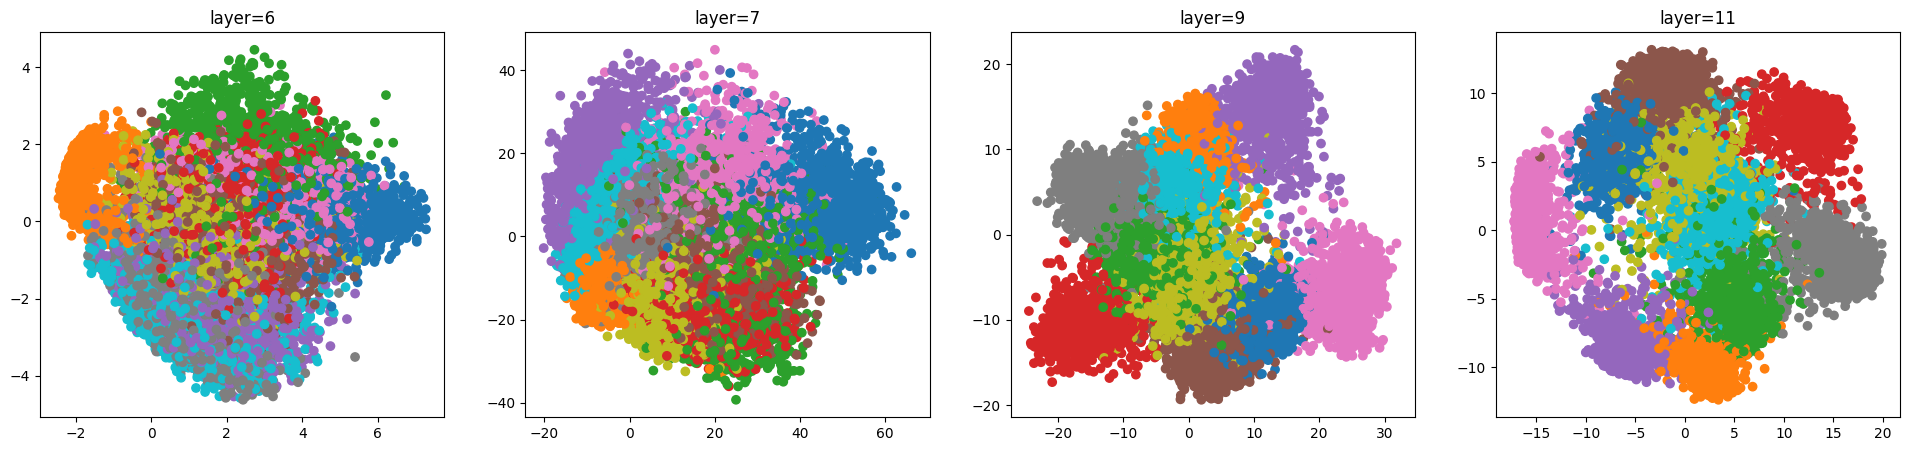

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for idx, layer in enumerate(monitored_layers):
    pca.fit(activations[layer].numpy())
    components = torch.tensor(pca.components_)
    projection = torch.mm(activations[layer], components.T)

    ax[idx].scatter(projection[:,0], projection[:,1], c=targets, cmap='tab10')
    ax[idx].set_title(f"{layer=}")

In [10]:
from loading import SequentialLoader
from layers import AdaptationModule
from initialization import IdentityInitializer
from plotting import ProjectionPlotter, LossPlotter

In [24]:
layer = 7
layer_dim = 120

nepochs = 20
nbatches = 938
batch_size = 64

lr = 0.001
margin = 1.0

In [25]:
# for training
adaptation_layer1 = AdaptationModule(layer_dim, IdentityInitializer(), lr=lr, margin=margin)
adaptation_layer2 = AdaptationModule(layer_dim, IdentityInitializer(), lr=lr, margin=margin)
triplet_loader = SequentialLoader(mnist_data, transforms=Unsqueeze())

In [26]:
# for testing
from testing import TestModule
projection_plot = ProjectionPlotter(2)
loss_plot = LossPlotter()
test_module = TestModule()

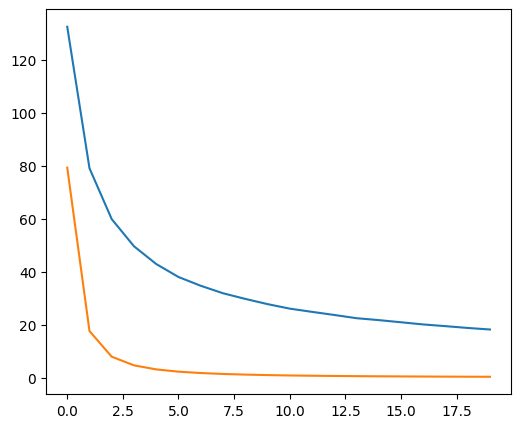

In [27]:
#training loop
embeddings = Embeddings(model, layers=[layer])
for epoch in range(nepochs):
    batch_loss1, batch_loss2 = 0, 0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in triplet_loader(batch_size):
            x = embeddings(x)
            x = adaptation_layer1(x)
            x = adaptation_layer2(x)
            
        batch_loss1 += adaptation_layer1.loss/batch_size
        batch_loss2 += adaptation_layer2.loss/batch_size
        
        adaptation_layer1.organize()
        adaptation_layer2.organize()
    test_outputs, targets = test_module([adaptation_layer1, adaptation_layer2], test_dataset=mnist_test_data, input_transforms=embeddings)
    loss_plot([batch_loss1, batch_loss2])

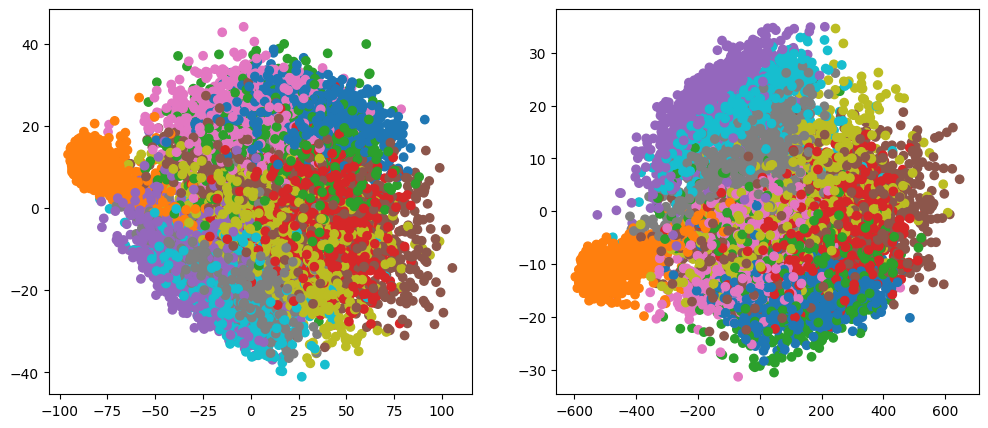

In [28]:
projection_plot(test_outputs, targets)

In [29]:
import transformations
from transformations import Scale, ToVector
from layers import DiscriminationModule
from initialization import DatasetInitializer
from testing import TestModule

lr = 0.01

transform = transformations.Compose([Scale(), ToVector()])
triplet_loader_dc = SequentialLoader(mnist_data, transforms=transform)

layer1 = DiscriminationModule(500, DatasetInitializer(mnist_data, transforms=transform), beta=0.98)
layer2 = AdaptationModule(500, IdentityInitializer(), lr=lr)
layer3 = AdaptationModule(500, IdentityInitializer(), lr=lr)
layer4 = AdaptationModule(500, IdentityInitializer(), lr=lr)

test_module_dc = TestModule()
loss_plot = LossPlotter()

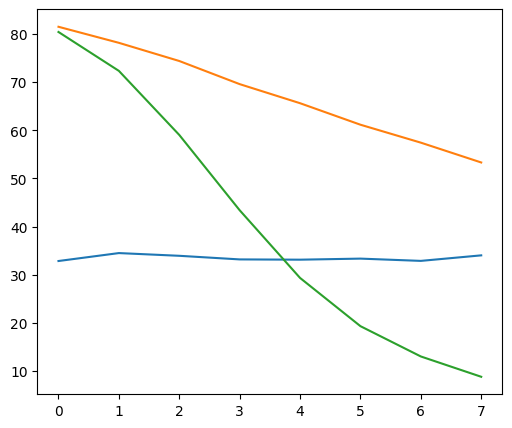

Testing:  42%|████▏     | 4246/10000 [10:05<14:09,  6.77it/s]

In [30]:
nepochs = 10
nbatches = 100
batch_size = 64
for epoch in range(nepochs):
    batch_loss1, batch_loss2, batch_loss3 = 0.0, 0.0, 0.0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in triplet_loader_dc(batch_size):
            x = layer1(x)
            x = layer2(x)
            x = layer3(x)
            x = layer4(x)
            
        batch_loss1 += layer2.loss/batch_size
        batch_loss2 += layer3.loss/batch_size
        batch_loss3 += layer4.loss/batch_size
        
        layer1.organize()
        layer2.organize()
        layer3.organize()
        layer4.organize()
        
    test_outputs, targets = test_module_dc([layer1, layer2, layer3, layer4], test_dataset=mnist_test_data, input_transforms=transform)
    loss_plot([batch_loss1, batch_loss2, batch_loss3])

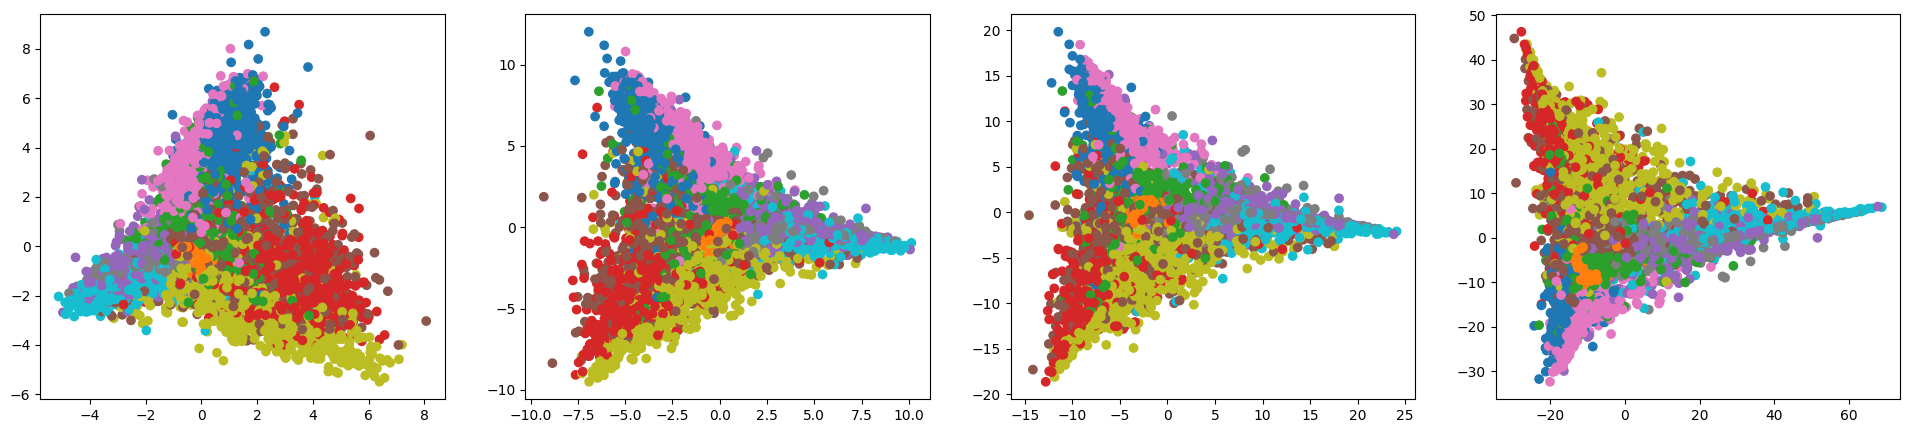

In [36]:
projection_plot = ProjectionPlotter(4)
projection_plot(test_outputs, targets)

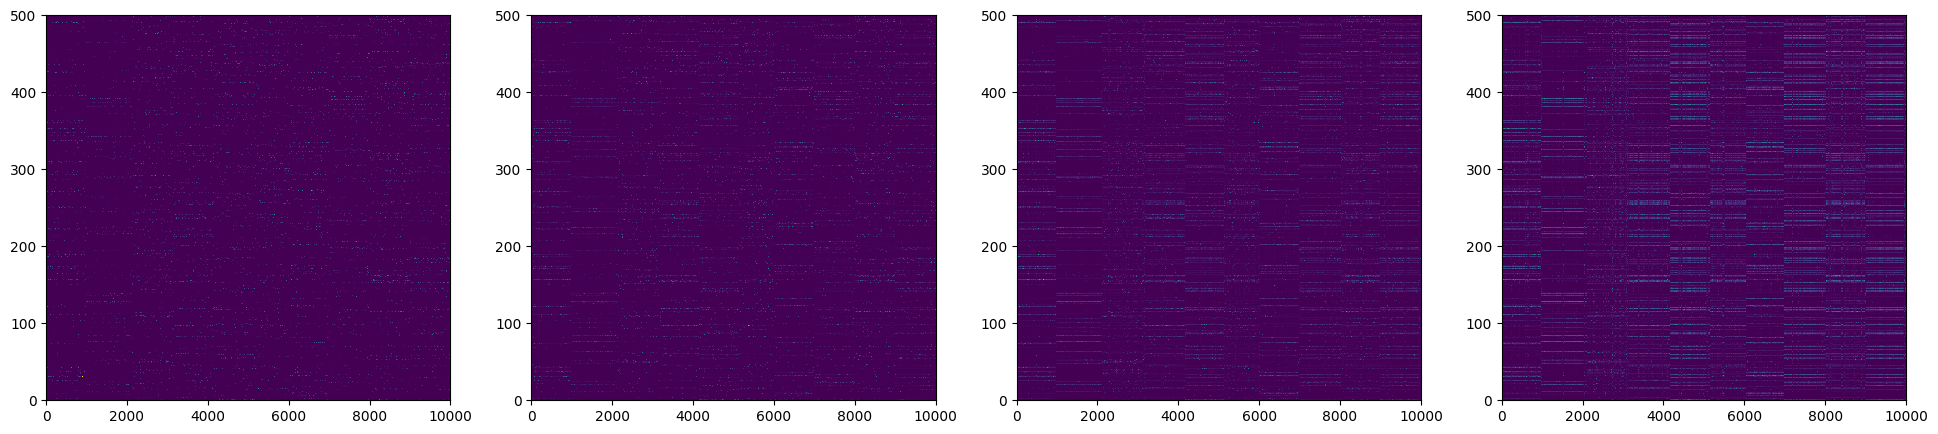

In [43]:
target_idxs = torch.argsort(torch.tensor(targets))
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
ax[0].pcolormesh(test_outputs[0][target_idxs,:].T)
ax[1].pcolormesh(test_outputs[1][target_idxs,:].T)
ax[2].pcolormesh(test_outputs[2][target_idxs,:].T)
ax[3].pcolormesh(test_outputs[3][target_idxs,:].T)

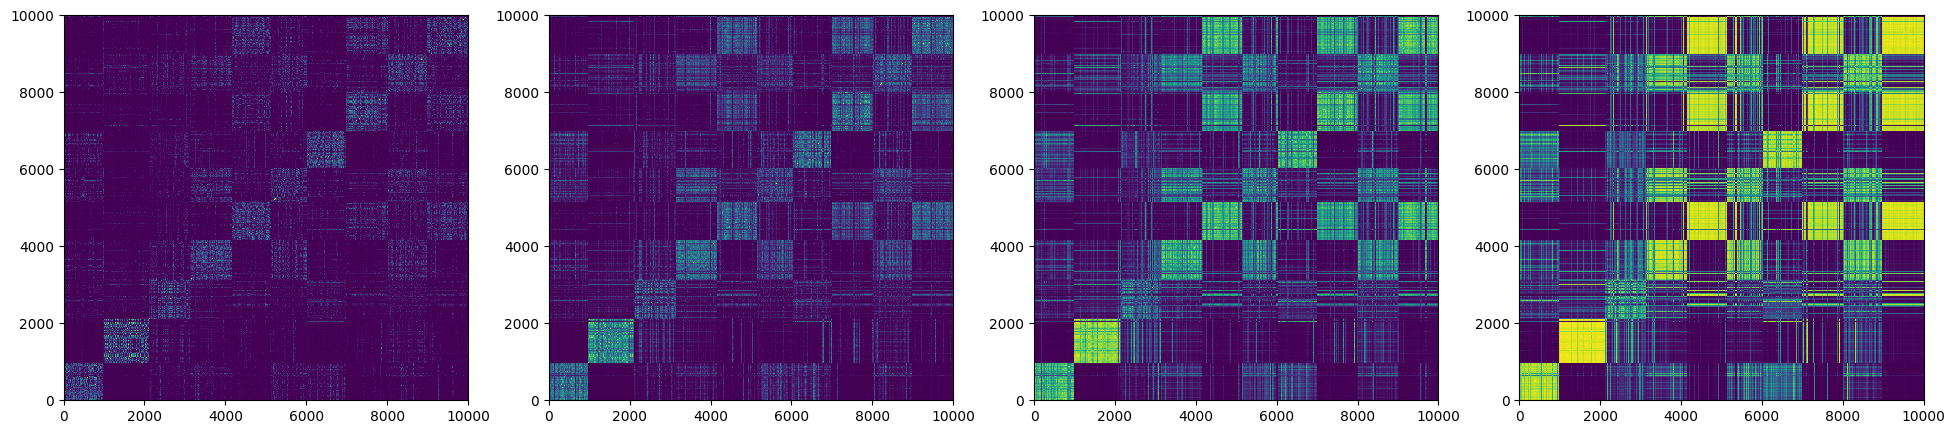

In [42]:
from plotting import SimilarityPlotter
test_outputs_sorted = {key: value[target_idxs,:] for key, value in test_outputs.items()}
SimilarityPlotter(4)(test_outputs_sorted)

In [47]:
x = torch.empty(0)
y = torch.cat((x, torch.rand(1, 5)), dim=0)
print(x.numel(), y.numel())

0 5
